# Assignment 5 Solution

This is my Assignment 5 solution.

It is **not** fully written up - I am focusing on the technical coding pieces.

It is also likely not optimal.  I have not aggressively optimimized what I can get out of the data.

## Setup

Let's import our base libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Binarizer, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

Set up an RNG:

In [3]:
import seedbank
seedbank.initialize(20211104)
rng = seedbank.numpy_random_state()

## Data Import

Let's import the full SBA data:

In [4]:
sba_full = pd.read_csv('../data/SBA/SBAnational.csv')
sba_full.info()

/home/MICHAELEKSTRAND/anaconda3/envs/cs533/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

For consistency, let's go ahead and set up our outcome variable right now.  First, are we missing any?

In [5]:
sba_full['MIS_Status'].isnull().sum()

1997

Ok, we have a small number of data points with no outcome variable. Drop them, and set a `PaidOff` variable:

In [6]:
sba = sba_full[sba_full['MIS_Status'].notnull()].copy()
sba['PaidOff'] = sba['MIS_Status'] == 'P I F'
len(sba)

897167

The amounts (disbursement gross, etc.) are strings, because they contain '$' and commas.  Let's turn those into numbers.

In [7]:
sba['DisbursementGross'] = sba['DisbursementGross'].str.replace(r'^\$|,', '').astype('f4')
sba['GrAppv'] = sba['GrAppv'].str.replace(r'^\$|,', '').astype('f4')
sba['SBA_Appv'] = sba['SBA_Appv'].str.replace(r'^\$|,', '').astype('f4')

/tmp/ipykernel_284805/990110382.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sba['DisbursementGross'] = sba['DisbursementGross'].str.replace(r'^\$|,', '').astype('f4')
/tmp/ipykernel_284805/990110382.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  sba['GrAppv'] = sba['GrAppv'].str.replace(r'^\$|,', '').astype('f4')
/tmp/ipykernel_284805/990110382.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  sba['SBA_Appv'] = sba['SBA_Appv'].str.replace(r'^\$|,', '').astype('f4')


And we want to parse out dates. What is the disbursment date?

In [8]:
sba['DisbursementDate'] = pd.to_datetime(sba['DisbursementDate'], format='%d-%b-%y')
sba['ApprovalDate'] = pd.to_datetime(sba['ApprovalDate'], format='%d-%b-%y')

And make a 25% train/test split:

In [9]:
train, test = train_test_split(sba, test_size=0.25, random_state=rng)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672875 entries, 636723 to 802466
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      672875 non-null  int64         
 1   Name               672863 non-null  object        
 2   City               672850 non-null  object        
 3   State              672867 non-null  object        
 4   Zip                672875 non-null  int64         
 5   Bank               671759 non-null  object        
 6   BankState          671754 non-null  object        
 7   NAICS              672875 non-null  int64         
 8   ApprovalDate       672875 non-null  datetime64[ns]
 9   ApprovalFY         672875 non-null  object        
 10  Term               672875 non-null  int64         
 11  NoEmp              672875 non-null  int64         
 12  NewExist           672771 non-null  float64       
 13  CreateJob          672875 non-null  int

And make our feature and target variables.  I'm going to drop chargeoff features, because they are direct proxies for the outcome (if it is paid in full, there is no chargeoff date or amount).

In [10]:
train_x = train.drop(columns=['ChgOffDate', 'ChgOffPrinGr', 'MIS_Status', 'PaidOff', 'BalanceGross'])
test_x = test.drop(columns=['ChgOffDate', 'ChgOffPrinGr', 'MIS_Status', 'PaidOff', 'BalanceGross'])

In [11]:
train_y = train['PaidOff']
test_y = test['PaidOff']

## Exploration

What is the distrbution of outcome variables?

<AxesSubplot:xlabel='PaidOff', ylabel='count'>

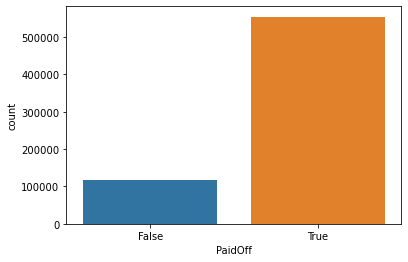

In [12]:
sns.countplot(x=train['PaidOff'])

The majority class is clearly paid-in-full, and by quite a bit.

So let's set up a majority-class output:

In [13]:
maj_train_out = pd.Series(True, index=train.index)
maj_test_out = pd.Series(True, index=test.index)

Let's go ahead and get its accuracy on test data:

In [14]:
accuracy_score(test_y, maj_test_out)

0.8238947443511138

Precision and recall are undefined and 0, respectively, because it never flags a default.

## Feature Selectors

Let's make a few transformer functions that will be useful for a lot of our models:

In [15]:
def f_is_new(X, *args):
    res = X['NewExist'] == 2
    return res.to_frame('IsNew')

In [16]:
def f_portion(X, *args):
    res = X['SBA_Appv'] / X['GrAppv']
    return res.to_frame('Portion')

And it's in the recession if it was disbursed before and due after the recession start date:

In [17]:
def f_is_recession(X, *args):
    start = pd.to_datetime('2007-12-01')
    end = pd.to_datetime('2009-06-30')
    db = X['DisbursementDate'] < start
    due = X['DisbursementDate'].copy()
    term = X['Term']
    for t in term.unique():
        tdo = pd.DateOffset(months=t)
        due[term == t] += tdo
    res = (due >= start) & (due <= end)
    return res.to_frame('Recession')

We'll then use these with function transformers:

In [18]:
FunctionTransformer(f_is_new).fit_transform(train_x)

,IsNew
636723,False
664089,False
886213,True
542760,False
701623,False
...,...
779125,False
283144,False
554096,False
830059,False


## Logistic Model

Let's build a logistic model!

In [19]:
tt_x, tu_x, tt_y, tu_y = train_test_split(train_x, train_y, test_size=0.2)

And get the tuning data majority class, this time with a `DummyClassifier` to demonstrate it:

In [20]:
maj_cls = DummyClassifier(strategy='most_frequent')
maj_cls.fit(tt_x, tt_y)
tu_ma = accuracy_score(tu_y, maj_cls.predict(tu_x))
tu_ma

0.8245365038082854

### Apply Simple Model
And now we're going to try a simple model:

In [21]:
fss_prep = ColumnTransformer([
    ('IsNew', FunctionTransformer(f_is_new), ['NewExist']),
    ('RealEstate', Binarizer(threshold=240), ['Term']),
    ('Portion', FunctionTransformer(f_portion), ['GrAppv', 'SBA_Appv']),
#     ('Recession', FunctionTransformer(f_is_recession), ['DisbursementDate', 'Term']),
    ('Gross', StandardScaler(), ['GrAppv'])
])
fss_pipe = Pipeline([
    ('prepare', fss_prep),
    ('classify', LogisticRegression(penalty='none'))
])
fss_pipe.fit(tt_x, tt_y)

Pipeline(steps=[('prepare',
                 ColumnTransformer(transformers=[('IsNew',
                                                  FunctionTransformer(func=<function f_is_new at 0x7f57d863e940>),
                                                  ['NewExist']),
                                                 ('RealEstate',
                                                  Binarizer(threshold=240),
                                                  ['Term']),
                                                 ('Portion',
                                                  FunctionTransformer(func=<function f_portion at 0x7f57d863eb80>),
                                                  ['GrAppv', 'SBA_Appv']),
                                                 ('Gross', StandardScaler(),
                                                  ['GrAppv'])])),
                ('classify', LogisticRegression(penalty='none'))])

Training accuracy:

In [22]:
accuracy_score(tt_y, fss_pipe.predict(tt_x))

0.8245476500092885

Tuning metrics:

In [23]:
accuracy_score(tu_y, fss_pipe.predict(tu_x))

0.824514211406279

This regression is just always classifying "paid in full", though.

### Expand Model

Now it's time to expand the model with some more features.

We're going to use `pd.get_dummies` instead of `OneHotEncoder` to deal with missing data better.

We're going to try including all of the numeric features.

In [24]:
def f_year(dates):
    return dates.dt.year.to_frame('Year')

In [25]:
def pd_dummies(X, *args):
    xf = pd.get_dummies(X).fillna(0)
    return xf

In [26]:
num_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('impute', SimpleImputer())
])
fss_prep = ColumnTransformer([
    ('IsNew', FunctionTransformer(f_is_new), ['NewExist']),
    ('RealEstate', Binarizer(threshold=240), ['Term']),
    ('Portion', FunctionTransformer(f_portion), ['GrAppv', 'SBA_Appv']),
    ('Recession', FunctionTransformer(f_is_recession), ['DisbursementDate', 'Term']),
    # ('Year', FunctionTransformer(f_year), 'DisbursementDate'),
    ('Numerics', num_pipe, ['NoEmp', 'CreateJob', 'RetainedJob']),
    ('State', FunctionTransformer(pd_dummies), 'State'),
])
# fss_state = ColumnTransformer([
#     ('State', OneHotEncoder(drop='first'), ['State'])
# ])
fss_pipe = Pipeline([
    #('prepare', Interact(fss_prep, fss_state)),
    ('prepare', fss_prep),
    ('classify', LogisticRegression(penalty='none', max_iter=500))
])
fss_pipe.fit(tt_x, tt_y)
tu_acc = accuracy_score(tu_y, fss_pipe.predict(tu_x))
tu_acc, tu_acc - tu_ma

(0.8258889095300018, 0.0013524057217164653)

A small improvement over majority!

And train accuracy:

In [27]:
accuracy_score(tt_y, fss_pipe.predict(tt_x))

0.8258461824261564

### Test Data

Now we'll get test accuracy.

In [28]:
fss_pipe.fit(train_x, train_y)
lr_test_out = fss_pipe.predict(test_x)

In [29]:
accuracy_score(test_y, lr_test_out)

0.8253927915396002

## Lasso

Let's put a lasso on this for some automatic feature selection.

In [30]:
num_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('impute', SimpleImputer())
])
l1_prep = ColumnTransformer([
    ('IsNew', FunctionTransformer(f_is_new), ['NewExist']),
    ('RealEstate', Binarizer(threshold=240), ['Term']),
    ('Portion', FunctionTransformer(f_portion), ['GrAppv', 'SBA_Appv']),
    ('Recession', FunctionTransformer(f_is_recession), ['DisbursementDate', 'Term']),
    # ('Year', FunctionTransformer(f_year), 'DisbursementDate'),
    ('Numerics', num_pipe, make_column_selector(dtype_include=np.number)),
    ('State', FunctionTransformer(pd_dummies), 'State')
])
l1_pipe = Pipeline([
    ('prepare', fss_prep),
    ('classify', LogisticRegressionCV(penalty='l1', cv=4, solver='saga', max_iter=500, n_jobs=4))
])
l1_pipe.fit(train_x, train_y)

Pipeline(steps=[('prepare',
                 ColumnTransformer(transformers=[('IsNew',
                                                  FunctionTransformer(func=<function f_is_new at 0x7f57d863e940>),
                                                  ['NewExist']),
                                                 ('RealEstate',
                                                  Binarizer(threshold=240),
                                                  ['Term']),
                                                 ('Portion',
                                                  FunctionTransformer(func=<function f_portion at 0x7f57d863eb80>),
                                                  ['GrAppv', 'SBA_Appv']),
                                                 ('Recession',
                                                  FunctionTransformer(func=<function f_is_recession at 0x7f57d863edc0>),
                                                  ['DisbursementDate', 'Term']),
               

What's our train accuracy?

In [31]:
accuracy_score(train_y, l1_pipe.predict(train_x))

0.8258532416867918

And test accuracy?

In [32]:
l1_test_out = l1_pipe.predict(test_x)
accuracy_score(test_y, l1_test_out)

0.8254106254347012

## Elastic Net

Let's do the elastic net:

In [33]:
num_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('impute', SimpleImputer())
])
en_prep = ColumnTransformer([
    ('IsNew', FunctionTransformer(f_is_new), ['NewExist']),
    ('RealEstate', Binarizer(threshold=240), ['Term']),
    ('Portion', FunctionTransformer(f_portion), ['GrAppv', 'SBA_Appv']),
    ('Recession', FunctionTransformer(f_is_recession), ['DisbursementDate', 'Term']),
    # ('Year', FunctionTransformer(f_year), 'DisbursementDate'),
    ('Numerics', num_pipe, make_column_selector(dtype_include=np.number)),
    ('State', FunctionTransformer(pd_dummies), 'State')
])
en_pipe = Pipeline([
    ('prepare', fss_prep),
    ('classify', LogisticRegressionCV(penalty='elasticnet', cv=4, l1_ratios=np.linspace(0, 1, 5), 
                                      solver='saga', max_iter=500, n_jobs=12))
])
en_pipe.fit(train_x, train_y)

Pipeline(steps=[('prepare',
                 ColumnTransformer(transformers=[('IsNew',
                                                  FunctionTransformer(func=<function f_is_new at 0x7f57d863e940>),
                                                  ['NewExist']),
                                                 ('RealEstate',
                                                  Binarizer(threshold=240),
                                                  ['Term']),
                                                 ('Portion',
                                                  FunctionTransformer(func=<function f_portion at 0x7f57d863eb80>),
                                                  ['GrAppv', 'SBA_Appv']),
                                                 ('Recession',
                                                  FunctionTransformer(func=<function f_is_recession a...
                                                  ['DisbursementDate', 'Term']),
                               

What's our train accuracy?

In [34]:
accuracy_score(train_y, en_pipe.predict(train_x))

0.8258547278469255

And test accuracy?

In [35]:
en_test_out = en_pipe.predict(test_x)
accuracy_score(test_y, en_test_out)

0.8254106254347012

## Random Forest

The random forest won't benefit from scaling.

But we'll through all the features at it, with some transforms for some of ours.

In [60]:
rf_prep = ColumnTransformer([
    ('IsNew', FunctionTransformer(f_is_new), ['NewExist']),
    ('RealEstate', Binarizer(threshold=240), ['Term']),
    ('Portion', FunctionTransformer(f_portion), ['GrAppv', 'SBA_Appv']),
    ('Recession', FunctionTransformer(f_is_recession), ['DisbursementDate', 'Term']),
    ('Numerics', SimpleImputer(), make_column_selector(dtype_include=np.number))
])

Now set up the pipeline. I'm going to limit the forest to depth-10 trees to reduce training time (and probably overfitting).

In [61]:
rf_pipe = Pipeline([
    ('prep', rf_prep),
    ('classify', RandomForestClassifier(max_depth=10))
])

Fit the model:

In [62]:
rf_pipe.fit(train_x, train_y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('IsNew',
                                                  FunctionTransformer(func=<function f_is_new at 0x7f57d863e940>),
                                                  ['NewExist']),
                                                 ('RealEstate',
                                                  Binarizer(threshold=240),
                                                  ['Term']),
                                                 ('Portion',
                                                  FunctionTransformer(func=<function f_portion at 0x7f57d863eb80>),
                                                  ['GrAppv', 'SBA_Appv']),
                                                 ('Recession',
                                                  FunctionTransformer(func=<function f_is_recession at 0x7f57d863edc0>),
                                                  ['DisbursementDate', 'Term']),
                  

Get the train accuracy:

In [63]:
accuracy_score(train_y, rf_pipe.predict(train_x))

0.9264202117778191

### Test Performance

In [64]:
rf_test_out = rf_pipe.predict(test_x)

In [65]:
accuracy_score(test_y, rf_test_out)

0.9246428762506019

## Summary Results

Finally, let's put together summary results!

In [66]:
results = pd.DataFrame({
    'Majority': maj_test_out,
    'Logistic': lr_test_out,
    'Lasso': l1_test_out,
    'ENet': en_test_out,
    'RF': rf_test_out
})
results

,Majority,Logistic,Lasso,ENet,RF
680332,True,True,True,True,False
598268,True,True,True,True,True
223331,True,True,True,True,True
650774,True,True,True,True,True
876314,True,True,True,True,True
...,...,...,...,...,...
491114,True,True,True,True,False
168594,True,True,True,True,True
149991,True,True,True,True,True
879999,True,True,True,True,True


In [67]:
metrics = pd.DataFrame({
    'Accuracy': results.apply(lambda ds: accuracy_score(test_y, ds)),
    'Precision': results.apply(lambda ds: precision_score(test_y, ds)),
    'Recall': results.apply(lambda ds: recall_score(test_y, ds)),
    # specificity is recall for the negative class
    'Specificity': results.apply(lambda ds: recall_score(~test_y, ~ds)),
})
metrics

,Accuracy,Precision,Recall,Specificity
Majority,0.823895,0.823895,1.000000,0.000000
Logistic,0.825393,0.825917,0.998539,0.015342
Lasso,0.825411,0.825920,0.998561,0.015342
ENet,0.825411,0.825920,0.998561,0.015342
RF,0.924643,0.936495,0.974626,0.690802


Make the metrics "tall" for plotting

In [68]:
metrics.index.name = 'Classifier'
tall_metrics = metrics.reset_index().melt(id_vars='Classifier', var_name='Metric')
tall_metrics.head()

,Classifier,Metric,value
0,Majority,Accuracy,0.823895
1,Logistic,Accuracy,0.825393
2,Lasso,Accuracy,0.825411
3,ENet,Accuracy,0.825411
4,RF,Accuracy,0.924643


/home/MICHAELEKSTRAND/anaconda3/envs/cs533/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


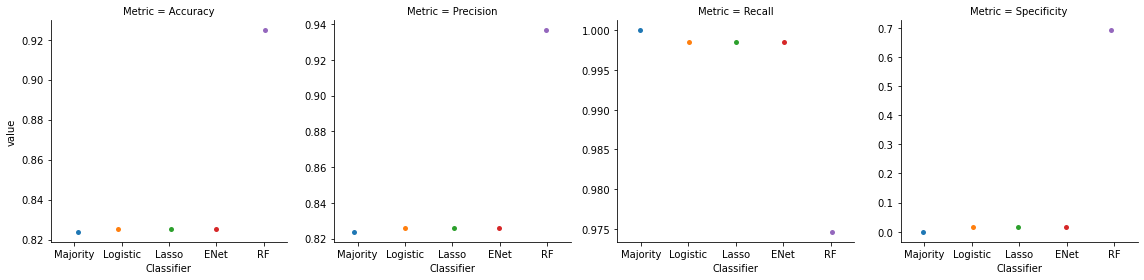

In [69]:
sns.catplot('Classifier', 'value', data=tall_metrics, col='Metric', sharey=False, height=4)

Now it's time for the cost.  SciPy confusion matrices are layed out as follows:

$$\begin{bmatrix}
\mathrm{TN} & \mathrm{FP} \\
\mathrm{FN} & \mathrm{TP}
\end{bmatrix}$$

And we want the following costs:
$$\begin{bmatrix}
0 & 1 \\
5 & 0
\end{bmatrix}$$

In [70]:
cost_matrix = np.array([
    [0, 1],
    [5, 0]
])
cost_matrix

array([[0, 1],
       [5, 0]])

With this, we can cost by computing the confusion matrix, multiplying elementwise by cost, and summing up the whole matrix:

In [71]:
def cost(preds):
    cmat = confusion_matrix(test_y, preds)
    cost = cmat * cost_matrix
    return np.sum(cost)

Test it out:

In [72]:
cost(results['RF'])

35658

What's the cost of each classifier?

In [73]:
costs = results.apply(cost).to_frame('cost').reset_index()
costs

,Classifier,cost
0,Majority,39499
1,Logistic,40243
2,Lasso,40223
3,ENet,40223
4,RF,35658


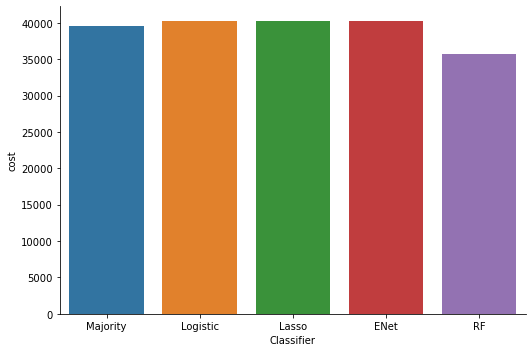

In [74]:
sns.catplot(x='Classifier', y='cost', data=costs, kind='bar', aspect=1.5)

Our RF seems to pretty clearly be the winner.

What are false positive rates?

In [75]:
def fpr(true_y, pred_y):
    fp = pred_y & (~true_y)
    tn = (~pred_y) & (~true_y)
    return np.sum(fp) / (np.sum(fp) + np.sum(tn))

In [76]:
def fnr(true_y, pred_y):
    fn = (~pred_y) & (true_y)
    tp = (pred_y) & (true_y)
    return np.sum(fn) / (np.sum(fn) + np.sum(tp))

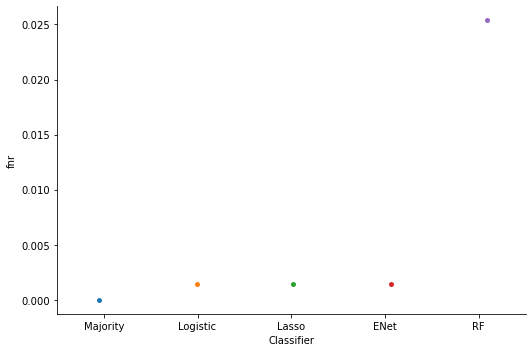

In [77]:
fnrs = results.apply(lambda ds: fnr(test_y, ds)).to_frame('fnr').reset_index()
sns.catplot(x='Classifier', y='fnr', data=fnrs, aspect=1.5)

Now let's break it down by group. First we need to get the groups:

In [78]:
res_class = results.assign(Status='Existing')
res_class.loc[test_x['NewExist'] == 2, 'Status'] = 'New'
res_class.head()

Classifier,Majority,Logistic,Lasso,ENet,RF,Status
680332,True,True,True,True,False,Existing
598268,True,True,True,True,True,Existing
223331,True,True,True,True,True,Existing
650774,True,True,True,True,True,Existing
876314,True,True,True,True,True,Existing


In [79]:
def all_metric(df, metric=precision_score):
    ys = test_y.loc[df.index]
    return df.drop(columns=['Status']).apply(lambda ds: metric(ys, ds))
group_prec = res_class.groupby('Status').apply(all_metric).reset_index()
group_prec

Classifier,Status,Majority,Logistic,Lasso,ENet,RF
0,Existing,0.828177,0.830215,0.830216,0.830216,0.941078
1,New,0.812968,0.814936,0.814945,0.814945,0.924701


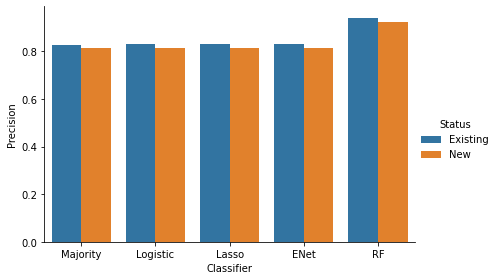

In [80]:
sns.catplot(x='Classifier', y='Precision', hue='Status', kind='bar', aspect=1.5, height=4,
            data=group_prec.melt(id_vars=['Status'], var_name='Classifier', value_name='Precision'))

Linear models have higher precision for new businesses, and RF has higher for existing businesses. We have not tested the significance of these differences.

In [81]:
group_fnr = res_class.groupby('Status').apply(all_metric, metric=fnr).reset_index()
group_fnr

Classifier,Status,Majority,Logistic,Lasso,ENet,RF
0,Existing,0.0,0.001117,0.001109,0.001109,0.023275
1,New,0.0,0.002357,0.002298,0.002298,0.030832


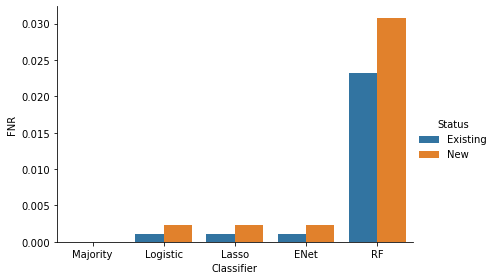

In [82]:
sns.catplot(x='Classifier', y='FNR', hue='Status', kind='bar', aspect=1.5, height=4,
            data=group_fnr.melt(id_vars=['Status'], var_name='Classifier', value_name='FNR'))

We see that linear models have higher FPRs for existing businesses, but the random forest has higher FPR for new businesses.

## Extra Code

I'm going to make a custom transformer that takes two pipelines and computes the interaction terms of one with the other, but not within the one.

In [59]:
class Interact(BaseEstimator, TransformerMixin):
    def __init__(self, xf1, xf2):
        self.xf1 = xf1
        self.xf2 = xf2
    
    def fit(self, *args):
        self.xf1.fit(*args)
        self.xf2.fit(*args)
    
    def transform(self, X):
        X1 = self.xf1.transform(X)
        X2 = self.xf2.transform(X)
        nr1, nc1 = X1.shape
        nr2, nc2 = X2.shape
        assert nr1 == nr2
        X12 = np.empty((nr1, nc1 * nc2))
        for i in range(nc1):
            for j in range(nc2):
                pos = i * nc2 + j
                X12[:, pos] = X1[:, i] * X2[:, i]
        res = np.concatenate(X1, X2, X12, axis=1)
        assert res.shape[0] == nr1